<div style="text-align: right"> Christopher Hyek </div>
<div style="text-align: right"> 9/25/2019 </div>
<h1 align="center"> Capstone Project Part 1</div>
<h2 align="center"> Japanese Dictionary Web Scraper </div>

# Index

[**Abstract**](#Abstract)

[**Imports**](#Imports)

[**The Web Scraper**](#1.0)

- [**Web Scraper Methods**](#1.0)

- [**Web Scraper Function**](#1.1)

- [**Web Scraper Results**](#1.2)

[**Dataframe Cleaning**](#EDA)

- [**Fixing Tags**](#2.1)

- [**Replacing Null Values**](#2.2)

- [**Removing Duplicates**](#2.3)

- [**Pronunciation Column**](#2.4)

- [**Additional Columns**](#2.5)

- [**Next Steps**](#2.6)

[**Visualizations**](#3.0)

- [**JLPT Tag Chart**](#3.1)

- [**Verb Tag Chart**](#3.2)

[**Final Thoughts**](#4.0)

## Abstract
What this  program is meant to do is to take information from the [Jisho.org](https://jisho.org/) website and scrape it into a readable and meaningful set of lists for the user to utilize. There have been many version of the following web scraper created and some of them do multiple tasks while others only obtain certain information due to what types of pages they are scraping. 

The Web Scraper is separated from the rest of the program because while this part deals with the acquisition and cleaning of the data, the second part works with how to process and condition that data for usage with NLTK which are two different goals and by extension I felt should be two different py files.

## Imports
The primary library for this part of the project is BeautifulSoup and will be more emphasized further down but one thing I wish to note is the usage of the time library. 

<i>Please scrape responsibly and use the time library to space out requests to the site, I do not condone irresponsible scraping.</i>

In [1]:
from bs4 import BeautifulSoup

import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import time

# 1.0

## The interior of the web scraper
Below are the methods I created that replace a good porition of the code for each time the web scraper is ran. One thing to note about them is the decent number of try/except calls that are put into it. Just in case some of the words within the dictionary lack certain elements we don't want to find that out 4/5 the way into the code running since it is not particularly fast, so we put a lot of it in try/except so that if something were to break the code that we can just move on and fix the issue after it's completed.

In [2]:
# The word finder function finds what is known as furigana and the actual word that is within the dictionary in Japanese.

def word_finder():
    word_dict['pronunciation'] = first_box.find(class_="furigana").text.strip("\n")
    word_dict['word'] = first_box.find(class_="text").text.strip("\n").strip(" ").strip("\n")

    
# The tag finder finds the common tag (which every word should have) and the JLPT tag (which is something that Japanese learners
# tend to use for determining their proficiency level). If the word does have this tag it is within the second tag slot after
# the common tag so that is why it is structured the way it is. If the word is not a JLPT word then a different tag will be 
# found there and then we know that the word is not one.

def tag_finder():
    try:
        word_dict['common tag'] = first_box.find(class_="concept_light-tag concept_light-common success label").text.strip('\n')
    except: 
        word_dict['common tag'] = 'None'
    try:
        word_dict['jlpt tag'] = first_box.find(class_='concept_light-tag label').text.strip('\n')
    except:
        word_dict['jlpt tag'] = 'None' 

# The audio finder will find us audio pronunciation of each word that we have scraped. However after doing some general skimming
# there does not seem to be one with every word, depending on how many have it we may not keep this column.

def audio_finder():
    try:
        audio = first_box.find("audio")
        word_dict['audio_link'] = audio.find("source")["src"]

    except:
        word_dict['audio_link'] = None

# The definition finder will create a dictionary that grabs the tag and definition of each tag that is found for the word.        
        
def definition_finder():
    meanings_wrapper = first_box.find(class_="meanings-wrapper")
    tags = meanings_wrapper.find_all(class_="meaning-tags")
    wrappers = meanings_wrapper.find_all(class_="meaning-wrapper")
    d = {}
    for tag, wrapper in zip(tags, wrappers):
        key = tag.text
        try:
            value = wrapper.find(class_="meaning-meaning").text
        except:
            value = wrapper.find(class_="meaning-definition meaning-representation_notes zero-padding").text
        d[key] = value 
    word_dict['meanings_wrapper'] = d      

# The word link finder will grab the html for each word that has only that word shown on it.    
    
def word_link_finder():
    try:
        word_dict['details_href'] = "https://jisho.org/word/{}".format(word_dict["word"])
    except:
        word_dict['details_href'] = None
    word_dictionaries_list.append(word_dict) 

# 1.1

## Initial Jisho Scraper
The code used to create the final result does break the "don't repeat yourself" mentality a bit but this was intentional and will be discussed further in. Below is the first rendition of the scraper that I used for the project that was at a satisfactory level to be moved onto the cleaning step. It's primary goal is to give me a look at every common word found within the [Jisho.org](https://jisho.org/) website. 

There are 21026 words found within the common tag and so we have a total of 1052 pages to scrape since each page comprises of 20 words. One set back (which was factored in upon creation) is that we don't want to overload the website and so there will be a limitation on the number of pages that we can scrape from Jisho per day--which is 75. So we'll need to run the program a total of 14 times to create the initial Jisho dataframe. Because of this separation, I did just make new copies of the the same function because it was over several days that I worked on this. However, I kept the unique portions commented out below because I do want them to be within the code but not called all at once.

#### Reference pages

The following numbers are how we split up the intial scraping. There could easily have been a loop that would obtain all of these but as previously noted I did not want to overload the server and start getting stuck in bad gateways to the site. 

1 - 76, 76 - 151, 151 - 226, 226 - 301, 301 - 376, 376 - 451, 451 - 526, 526 - 601, 601 - 676, 676 - 751, 751 - 826, 826 - 901, 901 - 976, 976 - 1052

Below we have the starting and ending page number that are put into the HTML variable further below to create each page hyperlink. The columns variable is left up here to indicate what we are obtaining from the end result each time.

In [3]:
# start_num = 1
# end_num = 76
# html = "https://jisho.org/search/%23common%20%23words?page={}"
# columns = ['word', 'pronunciation', 'common tag', 'jlpt tag', 'meanings_wrapper', 'details_href', 'audio_link']

In [4]:
# html = "https://jisho.org/search/%23common%20%23words?page={}"
# html_pages = [html.format(i) for i in range(start_num, end_num)]
# word_dictionaries_list = []

This is where we created each of the small portions of the database, we take the html page and scrape it for the classes that hold each of the words and then use all of the functions that we created above within to get our end result.

Below that we have the creation of each variable name and the conversion of each into a csv file.

In [5]:
# for i, html_page in enumerate(html_pages):
#     req = requests.get(html_page)
#     soup = BeautifulSoup(req.content, 'html.parser')
#     print(f"Request completed and soup built for page {i+1}")
#     word_boxes = soup.find_all(class_="concept_light clearfix")

#     for first_box in word_boxes:
#         word_dict = {}

#         word_finder()
#         tag_finder()
#         audio_finder()
#         definition_finder()
#         word_link_finder()

#         Used to check that words are being added and that the pages are being completed
#         print("total words = {}".format(len(word_dictionaries_list)))
#     print("Waiting")
#     time.sleep(10)

In [6]:
# df1 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df1.head(20)
# df1.to_csv('df1.csv', index=columns)

# df2 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df2.head(20)
# df2.to_csv('df2.csv', index=columns)

# df3 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df3.head(20)
# df3.to_csv('df3.csv', index=columns)

# df4 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df4.head(20)
# df4.to_csv('df4.csv', index=columns)

# df5 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df5.head(20)
# df5.to_csv('df5.csv', index=columns)

# df6 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df6.head(20)
# df6.to_csv('df6.csv', index=columns)

# df7 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df7.head(20)
# df7.to_csv('df7.csv', index=columns)

# df8 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df8.head(20)
# df8.to_csv('df8.csv', index=columns)

# df9 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df9.head(20)
# df9.to_csv('df9.csv', index=columns)

# df10 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df10.head(20)
# df10.to_csv('df10.csv', index=columns)

# df11 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df11.head(20)
# df11.to_csv('df11.csv', index=columns)

# df12 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df12.head(20)
# df12.to_csv('df12.csv', index=columns)

# df13 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df13.head(20)
# df13.to_csv('df13.csv', index=columns)

# df14 = pd.DataFrame(word_dictionaries_list, columns = columns)
# df14.head(20)
# df14.to_csv('df14.csv', index=columns)

# 1.2

## Final Results of Initial Scraping
This would take either two full weeks if we follow the regulations put on the site or about 4 hours with a VPN and a timer to not overload the server. 

Each of the dataframes seems to come back with mostly what I wanted but there is a lot of cleaning to be done which will be noted below after we create the combined dataframe.

### Create one mega DataFrame
Just to make sure we're in the right directory I have made sure to go directly to the folder with CD. Then we'll use glob to get what we need done.

In [7]:
cd

C:\Users\Atlas


In [8]:
cd Module 5 Capstone Project 

C:\Users\Atlas\Module 5 Capstone Project


In [9]:
cd Scrapped Jisho Files

C:\Users\Atlas\Module 5 Capstone Project\Scrapped Jisho Files


In [10]:
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [11]:
#combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])


# # # # # # # # # # # # # 
# # # #  WARNGING # # # # Make sure that ONLY the 14 csv you wish to combine are in the folder you are creating!!!
# # # # # # # # # # # # # 

# combined_csv.to_csv( "jisho_dict.csv", index=False, encoding='utf-8-sig')

### Combined DataFrame
Now that we have taken an entire folder of .csv files from the 14 times we scraped and we then combined them into a single dataframe, let's take a look at it for some general stats and to start on some basic cleaning. 

In [12]:
df = pd.read_csv('jisho_dict.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href,audio_link
0,学校,がっこう,Common word,JLPT N5,"{'Noun': 'school', 'Place': 'Gakkou', 'Wikiped...",https://jisho.org/word/学校,//d1vjc5dkcd3yh2.cloudfront.net/audio/c3eb3f15...
1,川,かわ,Common word,JLPT N5,"{'Noun': 'river; stream', 'Suffix': 'River; th...",https://jisho.org/word/川,//d1vjc5dkcd3yh2.cloudfront.net/audio/1e702f6c...
2,手,て,Common word,JLPT N5,"{'Noun': 'hand; arm', 'Noun, Noun - used as a ...",https://jisho.org/word/手,//d1vjc5dkcd3yh2.cloudfront.net/audio/e7d19a3f...
3,戸,と,Common word,JLPT N5,"{'Noun': 'door (esp. Japanese-style)', 'Place'...",https://jisho.org/word/戸,NaN
4,眼鏡,めがね,Common word,JLPT N5,"{'Noun': 'glasses; eyeglasses; spectacles', 'P...",https://jisho.org/word/眼鏡,//d1vjc5dkcd3yh2.cloudfront.net/audio/e9a3c89f...


# 2.0 

# EDA
Now that we have the fourteen smaller dataframes combined into the one that we'll be using for the remainder of the project, let's start going over basic EDA. 

The first thing that we'll go over with the data is correcting problems and filling null values.

To start we can just double check the size of the dataframe since we know there should be 21025 rows.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21025 entries, 0 to 21024
Data columns (total 7 columns):
word                21025 non-null object
pronunciation       16327 non-null object
common tag          21025 non-null object
jlpt tag            21025 non-null object
meanings_wrapper    21025 non-null object
details_href        21025 non-null object
audio_link          3951 non-null object
dtypes: object(7)
memory usage: 1.1+ MB


# 2.1 
## Fixing Tags
The JLPT tag columns will have issues based on the creation of the Web Scraper but we should double check both of the tag columns to be sure that they are doing what is intended of them.

### Common Tag
Below you will see that there are words that do not have the common tag listed below. Which is strange because that is what I had specifically had listed in the html pages that I used to create the dataframe. For now I will keep these words within the dataframe but I will most likely remove them later on due to the nature of the column.

In [14]:
df['common tag'].unique()

array(['Common word', 'None'], dtype=object)

In [15]:
df.loc[(df['common tag'] == 'None'), 'common tag'].count()

37

In [16]:
df.loc[(df['common tag'] == 'None'), 'word']

2983          ノーベル
2984           ソニー
2985        マクドナルド
2986         フェラーリ
2987          ニコラス
2988        フィリップス
2989          シャネル
2990          ポルシェ
6182            東宝
6183            三越
6184          伊勢神宮
6185           江戸川
6186            淀川
6188        日本郵政公社
8958           チロル
8959       ツタンカーメン
8960          デュポン
8961            トウ
8962          コダック
8963          ノイマン
8964         コンパック
8965           ゴジラ
8966         パッカード
8967         サントリー
8968         オリンピア
8969     フォルクスワーゲン
8970        フリードマン
8971          ミュラー
8972          モーリス
8973         サミュエル
8974           ライカ
8975        クライスラー
8976           ルノー
8977          ルモンド
8978         ロッテリア
19465           上野
19466           東芝
Name: word, dtype: object

#### For reference
Most of those words listed above this are pronouns or locations and are in fact not common words. They are very popular names and locations and are understable why they may come up in the [Jisho.org](https://jisho.org/) dictionary.

In [17]:
df.loc[(df['common tag'] == 'None')] = 'Uncommon word'

In [18]:
df.groupby('common tag')['word'].count()

common tag
Common word      20988
Uncommon word       37
Name: word, dtype: int64

#### Final Results
We'll keep the uncommon words for now but chances are we will remove them before we apply it to our program just because there are only supposed to be common words found within the first dataframe we create.

### JLPT Tag
For those of you that are unfamiliar with Japanese, the JLPT or Japanese Language Proficiency Test is a way for the Japanese government to quantify your Japanese language skills and qualify you for work in the country as well as potentially a boost to your chances of becoming a citizen. While it's not necessary by any means we are using this tag for people who wish to use the program created as a way to reference material for studying. It is also good metadata to keep for later on.

In [19]:
df['jlpt tag'].unique()

array(['JLPT N5', 'JLPT N4', 'JLPT N3', 'JLPT N2', 'JLPT N1', 'None',
       'Wanikani level 7', 'Wanikani level 57', 'Wanikani level 48',
       'Wanikani level 50', 'Wanikani level 28', 'Wanikani level 30',
       'Wanikani level 56', 'Wanikani level 47', 'Wanikani level 59',
       'Wanikani level 40', 'Wanikani level 53', 'Wanikani level 52',
       'Wanikani level 58', 'Wanikani level 38', 'Wanikani level 49',
       'Wanikani level 54', 'Wanikani level 24', 'Wanikani level 41',
       'Wanikani level 31', 'Wanikani level 34', 'Wanikani level 39',
       'Wanikani level 19', 'Wanikani level 29', 'Wanikani level 32',
       'Wanikani level 9', 'Wanikani level 45', 'Wanikani level 60',
       'Wanikani level 3', 'Wanikani level 18', 'Wanikani level 23',
       'Wanikani level 22', 'Wanikani level 36', 'Wanikani level 55',
       'Wanikani level 46', 'Wanikani level 21', 'Wanikani level 13',
       'Wanikani level 10', 'Wanikani level 42', 'Wanikani level 35',
       'Wanikani level 

#### For Reference
How I had coded the scraper to work was to take the second tag found within each word, which if the word was a JLPT tag word then it would have the JLPT tag in the second spot. This was intentional in that I could then remove all of the other non JLPT tags quite quickly in EDA once I scraped it.

For those who are wondering what Wanikani is, it is another website/application that is used for studying Kanji characters for Japanese. I won't be covering that in this project and I will probably only reference it here and that is it.

In [20]:
df.groupby('jlpt tag')['word'].count()

jlpt tag
JLPT N1               2605
JLPT N2               1629
JLPT N3               1663
JLPT N4                564
JLPT N5                650
None                 12234
Uncommon word           37
Wanikani level 1         1
Wanikani level 10       23
Wanikani level 11       21
Wanikani level 12       19
Wanikani level 13       19
Wanikani level 14       19
Wanikani level 15       20
Wanikani level 16       26
Wanikani level 17       33
Wanikani level 18       30
Wanikani level 19       25
Wanikani level 2        18
Wanikani level 20       23
Wanikani level 21       18
Wanikani level 22       26
Wanikani level 23       20
Wanikani level 24       32
Wanikani level 25        9
Wanikani level 26       20
Wanikani level 27       15
Wanikani level 28       21
Wanikani level 29       23
Wanikani level 3        12
                     ...  
Wanikani level 37       22
Wanikani level 38       28
Wanikani level 39       29
Wanikani level 4        20
Wanikani level 40       27
Wanikani level 41  

In [21]:
df.loc[(df['jlpt tag'] != 'JLPT N5') & (df['jlpt tag'] != 'JLPT N4') & (df['jlpt tag'] != 'JLPT N3') & (df['jlpt tag'] != 'JLPT N2') & (df['jlpt tag'] != 'JLPT N1'), 'jlpt tag'] = 'Not required' 

In [22]:
df.groupby('jlpt tag')['word'].count()

jlpt tag
JLPT N1          2605
JLPT N2          1629
JLPT N3          1663
JLPT N4           564
JLPT N5           650
Not required    13914
Name: word, dtype: int64

### Final Result
It is a bit more diverse than the common tag was but this is very good information for the project in terms of metadata and we'll be referencing this more later on.

There will be a pie chart within the visualization tab of this project but I want to clean up more before the visualization is made to avoid redundant recreation of it.

# 2.2
## Null Value Check
Now that we have two columns that I knew when scraping would be an issue let's go over a few of the other columns and see what we should work on next. And to start off we should clean out any Null values.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21025 entries, 0 to 21024
Data columns (total 7 columns):
word                21025 non-null object
pronunciation       16364 non-null object
common tag          21025 non-null object
jlpt tag            21025 non-null object
meanings_wrapper    21025 non-null object
details_href        21025 non-null object
audio_link          3988 non-null object
dtypes: object(7)
memory usage: 1.1+ MB


### Results
The biggest concerns I see are that pronunciation and audio_link have a ton of Null values.

After looking over the columns I think it is within the projects best intest to just drop the audio_link column and we'll keep the pronunciation column for now but upon closer inspection of the data obtained, it seems that it only actually obtained the furigana (which means the pronunciation of the kanji) and not the whole pronunciation of the word. Which means that for non-speakers the column is useless. And for speakers it is still ugly and choppy looking so we'll keep the column for now but it'll be completely reworked.

In [24]:
df = df.drop(['audio_link'], axis = 1)
df.head()

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
0,学校,がっこう,Common word,JLPT N5,"{'Noun': 'school', 'Place': 'Gakkou', 'Wikiped...",https://jisho.org/word/学校
1,川,かわ,Common word,JLPT N5,"{'Noun': 'river; stream', 'Suffix': 'River; th...",https://jisho.org/word/川
2,手,て,Common word,JLPT N5,"{'Noun': 'hand; arm', 'Noun, Noun - used as a ...",https://jisho.org/word/手
3,戸,と,Common word,JLPT N5,"{'Noun': 'door (esp. Japanese-style)', 'Place'...",https://jisho.org/word/戸
4,眼鏡,めがね,Common word,JLPT N5,"{'Noun': 'glasses; eyeglasses; spectacles', 'P...",https://jisho.org/word/眼鏡



## Non-Null Missing Value Check
Before we just skip to fixing up the pronunciation column, I want to make sure that the word, meanings_wrapper, and details_href columns are all taken care of as well.

#### Word Unique Value Check
We don't need to check if there is a word there, we should be checking for if the word there is a blank.

In [25]:
df.loc[(df['word'] == ''), 'word']

Series([], Name: word, dtype: object)

In [26]:
df.loc[(df['details_href'] == ''), 'word']

Series([], Name: word, dtype: object)

In [27]:
df.loc[(df['meanings_wrapper'] == '{}'), 'word']

1965         もしもし
1981         ようこそ
2023           おや
2078         やれやれ
2347          おっと
2367     お早うございます
3061          今晩は
7762          今日わ
8689         メルシー
8702         メルシー
11664    行ってらっしゃい
14750         今日は
18244          あら
18246          あら
19463        仕舞った
Name: word, dtype: object

#### For Reference
Most of the above words are common expressions or loan words in the Japanese language. And if you were to look closer we have several that are repeats of the same word but they have a unique row number on the left so that means we'll need to cull the dataframe of duplicates after we fix these blank meanings. 

There weren't enough words to really warrant a chunk of code for this. I went in and double checked that each word presented was in fact not blank on Jisho.org and then I copied the definition into a string. It seems that the pages with these used different class tags than all of the other 21,000 words which I find to be an odd choice of coding but I don't think I am someone who should be judging.

In [28]:
moshimoshi = {'Phrase': 'hello (e.g. on phone)', 'Phrase': 'excuse me! (when calling out to someone)'}
youkoso = {'Phrase': 'welcome!; nice to see you!'}
aya = {'Expression': 'oh!; oh? ah!'}
yareyare = {'Expression': 'oh!; ah!; oh dear!; good grief!; dear me!; thank God!'}
atto = {'Expression': 'uh-oh; oops; sorry'}
ohayou = {'Phrase': 'good morning'}
konbanwa = {'Phrase': 'good evening'}
konnichiwa = {'Phrase': 'hello; good day; good afternoon'}
mereji = {'Phrase': 'thank you'}
mereji2 = {'Phrase': 'thank you'}
itterashai = {'Phrase': 'have a good day; take care; see you'}
konnichiwa2 = {'Phrase': 'hello; good day; good afternoon'}
ara = {'Expression': 'oh; ah'}
ara2 = {'Expression': 'oh; ah'}
shimatta = {'Expression': 'darn it!; darn!; oops!; oh dear!; oh no!'}

In [29]:
df['meanings_wrapper'][1965] = moshimoshi
df['meanings_wrapper'][1981] = youkoso
df['meanings_wrapper'][2023] = aya
df['meanings_wrapper'][2078] = yareyare
df['meanings_wrapper'][2347] = atto
df['meanings_wrapper'][2367] = ohayou
df['meanings_wrapper'][3061] = konbanwa
df['meanings_wrapper'][7762] = konnichiwa
df['meanings_wrapper'][8689] = mereji
df['meanings_wrapper'][8702] = mereji2
df['meanings_wrapper'][11664] = itterashai
df['meanings_wrapper'][14750] = konnichiwa2
df['meanings_wrapper'][18244] = ara
df['meanings_wrapper'][18246] = ara2
df['meanings_wrapper'][19463] = shimatta

In [30]:
df.loc[(df['meanings_wrapper'] == '{}'), 'word']

Series([], Name: word, dtype: object)

In [31]:
df['meanings_wrapper'][1965]

{'Phrase': 'excuse me! (when calling out to someone)'}

#### Final Results
Now that we have cleaned out any non-null blanks and null values as well as removed problem columns (the audio link column) we are pretty much ready for the next phase of EDA cleaning.

# 2.3
## Duplicate Removal
First we'll find the duplicates to see how many that we even have. Given that our dataframe is 21026 values I wouldn't think that there would be a lot but given some of the previous mistakes we found from combing over null values and other parts of EDA though, I would not be surprised if there are a couple.

In [32]:
df.duplicated(subset='word', keep='first').sum()

3467

There are 3467 duplicates found within the dataframe if we do not count the first of each that we found, and to reconfirm this I found one's unique row number and used loc to find the duplicates and listed it below. 

In [33]:
df.loc[(df['word'] == '無形文化財')]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
1506,無形文化財,むけいぶんかざい,Common word,Not required,"{'Noun': 'intangible cultural asset', 'Wikiped...",https://jisho.org/word/無形文化財
1525,無形文化財,むけいぶんかざい,Common word,Not required,"{'Noun': 'intangible cultural asset', 'Wikiped...",https://jisho.org/word/無形文化財
1585,無形文化財,むけいぶんかざい,Common word,Not required,"{'Noun': 'intangible cultural asset', 'Wikiped...",https://jisho.org/word/無形文化財
20943,無形文化財,むけいぶんかざい,Common word,Not required,"{'Noun': 'intangible cultural asset', 'Wikiped...",https://jisho.org/word/無形文化財
20996,無形文化財,むけいぶんかざい,Common word,Not required,"{'Noun': 'intangible cultural asset', 'Wikiped...",https://jisho.org/word/無形文化財


#### For Reference
While the above is probably one of the more aggregious examples of duplicates, the fact that we have nearly 15% of the current dataframe in duplicates is concerning and so this culling will significantly clean things up.

This also emphasizes that the data that we obtained from Jisho.org has mistakes within it to a greater degree and we should be skeptical and do more tests within EDA before continuing.

In [34]:
df.drop_duplicates(subset='word', keep = 'first', inplace = True)

In [35]:
df.loc[(df['word'] == '無形文化財')]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
1506,無形文化財,むけいぶんかざい,Common word,Not required,"{'Noun': 'intangible cultural asset', 'Wikiped...",https://jisho.org/word/無形文化財


In [36]:
df.duplicated(subset='word', keep='first').sum()

0

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 21022
Data columns (total 6 columns):
word                17558 non-null object
pronunciation       13357 non-null object
common tag          17558 non-null object
jlpt tag            17558 non-null object
meanings_wrapper    17558 non-null object
details_href        17558 non-null object
dtypes: object(6)
memory usage: 960.2+ KB


# 2.4
## Pronunciation Column Problems
At this point after going through the website I have determined that they do not have anywhere within it the actual pronunciation of the word in a way that does not come in a split form that only speakers of the language would understand.

Below I have listed several examples of what I mean and why they are all correct/incorrect.
The first loc is showing a word where the pronunciation tag is correct, the second one is showing one where it does not work, and the third shows how it deals with words that are super mixed.

In [38]:
df.loc[(df['word'] == '学校')]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
0,学校,がっこう,Common word,JLPT N5,"{'Noun': 'school', 'Place': 'Gakkou', 'Wikiped...",https://jisho.org/word/学校


This one has a correct pronunciation, and the reason is because the entire word is made of Kanji (the Japanese script that is loaned from Chinese script) so each character has a specific pronuncation.

In [39]:
df.loc[(df['word'] == '遊び')]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
232,遊び,あそ,Common word,JLPT N4,"{'Noun, Noun - used as a suffix': 'playing', '...",https://jisho.org/word/遊び


This one has a semi incorrect pronunciation because the first character is listed within pronunciation but the second half is not included because that character only has one pronunciation.

In [40]:
df.loc[(df['word'] == '役に立つ')]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
1436,役に立つ,やくた,Common word,JLPT N4,"{'Expression, Godan verb with tsu ending': 'to...",https://jisho.org/word/役に立つ


This one is terribly incorrect because the first and third character are listed in the pronunciation column but the second and fourth are not. Moreover if you do not speak Japanese you wouldn't know where the first character ends and the third character starts within that tag due to how the website we scraped from is formated (the pronunciation column was listed over the characters on the website which made it semi readable but when scraped they do not provide a space).

In [41]:
df[df['pronunciation'].isnull()].count()

word                4201
pronunciation          0
common tag          4201
jlpt tag            4201
meanings_wrapper    4201
details_href        4201
dtype: int64

In [42]:
df[df['pronunciation'].isnull()]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
293,より,NaN,Common word,JLPT N5,"{'Particle': 'than', 'Adverb': 'from; out of; ...",https://jisho.org/word/より
1037,Ｙシャツ,NaN,Common word,JLPT N5,{'Noun': 'shirt; business shirt; dress shirt'},https://jisho.org/word/Ｙシャツ
1349,と,NaN,Common word,JLPT N3,"{'Particle, Conjunction': 'if; when', 'Noun': ...",https://jisho.org/word/と
1922,です,NaN,Common word,Not required,{'Expression': 'be; is'},https://jisho.org/word/です
1940,チケット,NaN,Common word,Not required,"{'Noun': 'ticket', 'Other forms': 'ティケット、テケツ',...",https://jisho.org/word/チケット
1942,ほら,NaN,Common word,Not required,{'Other forms': 'look!; look out!; hey!; look ...,https://jisho.org/word/ほら
1943,つい,NaN,Common word,Not required,{'Adverb': 'just (now)'},https://jisho.org/word/つい
1947,わくわく,NaN,Common word,Not required,"{""Adverb, Adverb taking the 'to' particle, Sur...",https://jisho.org/word/わくわく
1948,アドバイス,NaN,Common word,Not required,"{'Noun, Suru verb': 'advice', 'Other forms': '...",https://jisho.org/word/アドバイス
1949,セールスマン,NaN,Common word,Not required,{'Noun': 'salesman'},https://jisho.org/word/セールスマン


#### For reference
These pronunciations are null because the words do not have a kanji in them, they're comprised entirely of katakana or hiragana which mean that these are easy fixes. We just need to fill the pronunciation column with the word column for these ones. But first let's make them non-nulls

In [43]:
df['pronunciation'].fillna("Empty", inplace = True)

In [44]:
df[df['pronunciation'].isnull()]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 21022
Data columns (total 6 columns):
word                17558 non-null object
pronunciation       17558 non-null object
common tag          17558 non-null object
jlpt tag            17558 non-null object
meanings_wrapper    17558 non-null object
details_href        17558 non-null object
dtypes: object(6)
memory usage: 960.2+ KB


### Possible Solution
So once we filled the null values it was clear that they were all just words that we could fill in with the word column. But now we need to convert the word column to the pronunciation column and then do the same for all of the words that only have partial pronunciations listed.

#### Pronunciation solution
We have a three part issue with the pronunciation column:

    1) Words that do not have kanji just do not have pronunciation values
    2) Words that show up in the column are only pronunciations of kanji, not of hiragana or katakana
    3) Words that are a mix of them will probably need to be manually fixed

## What order to fix these in? 
Well the first one will be the one that I need to manually fix from part 3. Those ones will be the hardest to deal with so I will manually go in and fix those.

Then we'll go through all of the pronunciation column labels a second time when we go to automate the easier labels in part 2 that need fixing.

Then we'll convert all of the words that have no kanji to pronunciation at the end since they don't need any fixing from part 1.

#### Part 3 
Without going too much into detail, it was faster to manually go over the list of words that had two or more transitions in a single word between scripts. While it would be possible to use the method I use later down to split the words found and figure it out from there, the sheer size of the dataframe versus a few sentences that my method is meant to handle don't compare. So instead I created a loop and went through what came up.

In [46]:
# size_list = []
# for ind in range(len(df)):
#     print(df.loc[ind, 'word'], len(df['word'][ind]))
#     size_list.append(df.loc[ind, 'word'])

In [47]:
# new_size_list = []
# for x in size_list:
#     if len(x) > 2:
#         print(x)
#         new_size_list.append(x)

In [48]:
multi_script_word_list = ['買い物', '贈り物', '乗り物', '押し入れ', '女の子', 'お父さん', 'お母さん', '男の子', '食べ物', '飲み物', '真っ直ぐ', 'お祖母さん',
'お兄さん', 'お姉さん', '朝ご飯', 'お手洗い', 'お巡りさん', '乗り換え', '明け方', '引き分け', '回り道', '人差し指', '思い出す', '間に合う', '赤ん坊',
'役に立つ', '打ち込み', '生き埋め', '死に体', '取り消し', '生き埋め', '味の素', '巻き返し', '江戸っ子', '買い占め', '埋め立て地', '申し訳ありません',
'跳び上がる', 'どうも有難う', '限り限り', 'お休みなさい', '決め付ける', 'どう致しまして', '選り分ける', 'お帰りなさい', '焼き鳥', '捨て子', '書き初め', 
'掛け軸', '待ち伏せ', 'に就いて', 'と言う', 'に因って', '飛び火', '組み替え', '明け暮れ', '送り先', '送り先', '悔し泣き', '置き場', '押し切る', 
'飛び火', '積み重ね', '突き上げる', '受け皿', '買い出し', '売り込み', '埋め立て', '挟み撃ち', '埋め立て', '埋め立て', '繰り延べ', '分かれ目', 
'聞き手', '繰り延べ', '持ち合い', '兼ね合い', '兼ね合い', '落ち着いた', '後遺症', '落ち着いた', '立ち直り', '呼び水', '落ち着いた', '立ち直り', 
'後ろ盾', '太り肉', '太り肉', '行き詰まり', '浮き彫り', '受け渡し', '撃ち止める', '追い打ち', '押し出し', '返り咲き', '返り咲き', '切り替え', 
'切れ味', '切れ味', '締め付け', '垂れ幕', '飛び込み', '取り込み', '取り調べ', '読み取り', '読み取り', '割り込み', '行き過ぎる', '据え置き',
'削り節', '据え置き', '削り節', '触れ合い', '引き取り', '火付け役', '気に入り', '繰り上げ', '決め球', '言い渡し', '決め球', '言い渡し',
'担い手', '負い目', '負い目', '思い思い', '取り下げ', '取り口', '生みの親', '見せ場', '上っ調子', '生みの親', '明け暮れ', '生みの親',
'明け暮れ', '配り物', '歩み寄り', '勝ち星', '取り計らい', '勝ち越し', '切り下げ', '切り捨て', '在りし日', '打ち合い', '打ち合い', '積み重ね',
'積ん読', '繰り出し梯子', '聞き書き', '振り付け', '立ち上がり', '振り付け', '立ち上がり', '怒鳴り込む', '洗い上げる', '残った分', '飛び出し',
'拾い物', '飢え死に', '焼き芋', '継ぎ接ぎ', '食い下がる', '呼び捨て', '揺ら揺ら', '引き締まる', '立て替える', '見す見す', '見す見す', '追い抜く',
'恐る恐る', '立ち読み', '話し込む', '預かり所', '押し売り', '炊き出し', '包み紙', '根掘り葉掘り', '乗り越し', '食み出す', '知らず知らず', '立て札',
'泣き顔', '逃げ足', '認め印', '隣り合わせ', '間に合わせ', 'やり切れない', '思い上がる', '方が良い', 'っ放し', 'お詫び', 'に際して', '盛り付け',
'し続ける', '余っ程', '何とも言えない', '絞り込む', '売れ筋', 'あり合わせ', 'みじん切り', '冷え性', '日焼け止め', '食べ歩き', '気の向くままに',
'食べ歩き', '気の向くままに', 'ほんの少し', '資源エネルギー庁', '取り立て', '入り込み', '預け入れる', '向かって左', 'でも無い' ,
'では無いか', 'ことが出来る', 'ブチ切れ', '生まれ育つ', 'に限って', '最後の舞台', '有って無い', '有って無い', 'に向けて', '知っての通り',
'では無い', '無くちゃいけない', '並び替える', 'お久しぶり', 'お手数ですが', 'おめでとう御座います', 'お腹の子', 'じゃ無いか', '可能性が高い',
'憧れの的', 'に当たっては', '売れ筋ランキング', 'ような気がする', 'お支払い方法', '支払い方法', '何と言うか', 'ピン撥ね', 'の度に', 'ドル買い',
'申し上げる', '引っ越す', 'ご存じ', '乗り換える', '引き出し', '召し上がる', '差し上げる', 'お釣り', 'ご主人', '受け取る', '話し合う', '繰り返す',
'繰り返す', '飛び出す', '思い出', '付き合い', '生き物', '引っ越し', '切っ掛け', '立ち上がる', '兎に角', '其の儘', '通り過ぎる', '取り上げる',
'気の毒', '申し込む', '我が儘', '生け花', '持ち上げる', '知り合い', '当たり前', '取り消す', '売り上げ', '呼び出す', '話し合い', '生き生き',
'締め切り', '日の出', '真っ暗', '売れ行き', '真っ白', '問い合わせ', '絵の具', '貸し出し', '締め切る', '付き合う', '落ち着く', '振る舞う',
'矢っ張り', '引き受ける', '取り出す', '飛び込む', '立ち止まる', '兎も角', '申し訳ない', '突っ込む', '組み立てる', '独り言', '真っ青',
'だらし無い', '蒸し暑い', '行き成り', '引き返す', '言い出す', 'お早う', '行き成り', '引き返す', '呉れ呉れも', '呉れ呉れも', 'お代わり',
'打ち合わせ', '溶け込む', '受け持つ', '引き止める', '取り入れる', '末っ子', '酔っ払い', '酔っ払い', '釣り合う', '売り切れる', '末っ子',
'突き当たる', '好き嫌い', '引っ込む', 'お八つ', '追い越す', '待ち合わせる', '真っ黒', '好き好き', '日の入り', '払い戻す', 'お参り',
'払い込む', '組み合わせ', '書き取り', '突き当たり', '差し支え', '掛け算', 'お願いします', 'ひっくり返る', 'やむを得ない', '受け入れる',
'申し出', '立ち寄る', '言い訳', '申し込み', '抜け出す', '受け継ぐ', '落ち込む', '打ち込む', '取っ手', '取っ手', '取っ手', '落ち葉',
'落ち葉', '追い出す', '問い合わせる', '押し込む', '追い込む', '取り扱い', '引き上げる', '引き取る', '引き上げる', '割り当て', '使い道',
'割り当て', '夕暮れ', '組み込む', '夕暮れ', '受け入れ', '受け入れ', '受け止める', '打ち切る', '投げ出す', '受け止める', '投げ出す',
'引き下げる', '売り出す', '日の丸', '日の丸', '切れ目', '張り紙', '読み上げる', '切れ目', '申し入れる', '建て前', '取り戻す', '引き起こす',
'取り除く', '取り分け', '逃げ出す', '取り組む', '乗り込む', 'お祖父さん', '差し出す', '申し出る', '取り扱う', '割り込む', '付け加える',
'代わる代わる', '受け付ける', '持て成す', '待ち遠しい', '備え付ける', '待ち合わせ', '案の定', '取り寄せる', '取り寄せる', '盛り上がる',
'良し悪し', '組み合わせる', '馴れ馴れしい', '引っ掛ける', '引っ掛ける', '馴れ馴れしい', '取り締まる', '馴れ馴れしい', '取り締まる',
'取り巻く', '差し掛かる', '差し支える', '打ち合わせる', 'たどり着く', 'お使い', 'かき回す', '切り札', 'お化け', 'お化け', '一人っ子',
'一人っ子', '使い捨て', '呼び出し', '呼び出し', '呼び出し', '打ち切り', '呼び出し', '目覚まし時計', 'ご覧になる', 'ひな祭り',
'ひな祭り', 'かも知れない', '有り難う', '夫れ夫れ', '其れ共', 'お目出度う', '踊り子', '取り組み', '床の間', 'くっ付く', '枯れ木',
'くっ付ける', 'お陰様で', '送り仮名', 'そう言えば', 'お大事に', '振る舞い', '知り合う', '我が国', '我が家', '持ち主', '使い方',
'振り返る', '歩き回る', '巻き込む', '役に立たない', '引き継ぐ', '押し入る', '叫び声', '言い方', '生み出す', '思い切って',
'吹き出す', '吹き出す', '繰り返し', 'お手伝い', '持ち出す', '走り出す', '言い分', '目の前', '間に合わせる', '間に合わせる',
'書き込む', '注ぎ込む', '道のり', '書き方', '成り行き', '空き家', '曲がり角', '持ち込む', '書き上げる', '書き上げる',
'吸い込む', '読み書き', '住み心地', '万が一', 'お話し中', '引き渡す', '引き渡す', '困り果てる', '引き渡す', '取り残す',
'知らん顔', '裏切り者', '感じ取る', '感じ取る', '持ち帰る', '言い渡す', '読み方', '映し出す', '映し出す', '折り合い',
'連れ去る', '書き換える', '払い戻し', '待ち構える', '取り決め', '払い戻し', '入り込む', '置き去り', '浮かび上がる',
'申し立て', '真っ最中', '取り決める', '真っ最中', '空き缶', '取り決める', '浮かび上がる',  '読み物', '真っ最中', '引き締め', '塗り替える',
'塗り替える', '行き過ぎ', '流れ込む', '築き上げる', '駆け引き', '引き締め', '駆け引き', '空き地', '指し示す', '留め金', '笑い声',
'笑い声', '譲り渡す', '小売り店', '走り高跳び', '開き直る', '開き直る', '踏ん張る', '踏ん張る', '草の根', '踏ん張る', '決め手',
'草の根', '草の根', '飛び交う', '言い回し', '二つ目', '後ろ向き', '後ろ向き', '後ろ向き', '立ち往生', '持ち前', '申し入れ',
'めぐり合う', '吸い殻', '持ち家', '食い違い', '食い込む', '伸び率', '引き下げ', '生え抜き', '競り合う', '真っ向', '引き受け',
'日の目', '送り込む', '引き継ぎ', '引き継ぎ', '送り込む', '入れ替え', '取り壊し', '引き合い', '振り切る', '取り壊し', '苦肉の策',
'兼ね備える', '兼ね備える', '切り抜き', '語り口', '買い占める', '語り口', '付け根', '引き合い', '付け根', '生き残り', '立ち退き',
'混ぜ合わす', '持ち株', '立ち退き', 'やって来る', 'にも関わらず', '乗り遅れる', '連れて行く', '取り掛かる', '立ち去る', '成し遂げる',
'酔っ払う', '向こう側', '立ち直る', '打ち明ける', 'お気に入り', '噛み付く', '引き付ける', '振り向く', 'やり繰り', '引き裂く', '打ち上げる',
'生き方', '押し付ける', '至る所', '雇い主', '割り当てる', '言い換える', '付け込む', '持ち物', 'お医者さん', 'お仕舞い', '見た目',
'やり直す', '取り返す', '生き甲斐', '乗り出す', '吹き込む', '独り占め', '日に日に', '行き渡る', '行き渡る', '起き上がる', '持て成し',
'折り返し', '飛び下りる', '作り上げる', '取り柄', '食い止める', '握り締める', '書き直す', 'びしょ濡れ', '有り触れた', '歩み寄る',
'差し当たり', '有り触れた', '思う存分', '引き離す', '話し言葉', '思い切る', 'やり取り', '持ち堪える', '言い返す', 'ぶら下がる',
'見ず知らず', '擦れ擦れ', '隣り合う', '言い表す', '突き刺す', '乗り回す', '見る見る', 'お絞り', '行き来', '乗り越す', '吹き出物',
'取り外す', '立ち退く', '浮き浮き', '話し声', '踏み切る', '立て続け', '割り引く', '割れ目', '張り出す', '立て直す', '冷や汗',
'引き延ばす', '化け物', '触れ合う', '立て込む', '洗い物', '八つ当たり', '丸め込む', '思い直す', '思い当たる', '冷え込む',
'浮き浮き', '八つ当たり', '乗り降り', '引き戻す', '引け目', '盛り上げる', '絶え間なく', '巻き添え', 'か弱い', '貸し出す',
'やり過ごす', '書き言葉', '逃げ道', '申し分無い', '行き止まり', '寄り道', '泣き声', '引き締める', '縫い目', '互い違い',
'書き言葉', '探し回る', '差し伸べる', '作り笑い', '切り捨てる', '持ち直す', '汲み取る', '売り込む', 'ちり取り', 'に対して',
'に対する', 'に関して', '長い間', 'そう言う', '若い頃', '若い頃', 'こう言う', 'お願い', 'どう言う', 'ついて行く', '話し方',
'ないと行けない', '一ヶ月', 'し過ぎる', 'お婆ちゃん', 'あっという間に', '帰り道', 'あり得ない', '手当たり次第', '数ヶ月',
'作り出す', 'どう仕様もない', '考え直す', '考え直す', '動き出す', '乗り切る', '差し込む', '買い得', 'お持て成し', 'お持て成し',
'立ち上げる', 'お馴染み', '探し物', '思い描く', '繰り広げる', '飲み会', '待ち合わせ場所', 'いつも通り', '何時に無く', '有り勝ち',
'貼り付ける', '子供の頃', '遣っ付ける', '申し訳', 'うつ伏せ', 'はみ出る', '差し引き', '落とし物', '打ち消す', '落とし物',
'張り切る', '割り算', '四つ角', '透き通る', '打ち消す', '天の川', '真っ二つ', '茶の間', '聞き取り', '何れ何れ', '折り返す' ,
'くじ引き', '突っ張る', '折り返す', '情け深い', '折り返す', '情け深い', '駆け足', '行き違い', '打ち消し', '取り次ぐ', '切り替える',
'注ぎ込む', '一つ一つ', '見え隠れ', '差し止め', '重ね合わせ', '振り子', '振り子', '君が代', '君が代', '死に体', '踏み絵', 
'取り消し', '死に体', '踏み絵']

In [49]:
len(multi_script_word_list)

809

Surprisingly this only took a few minutes to go over due to Jupyter notebooks actually using a different script bold for the different scripts found within Japanese. But this may also have some human error so we'll have to watch out for that later on.

In [50]:
no_dup_list = list(set(multi_script_word_list))

In [51]:
len(no_dup_list)

699

Now that we have a list of multi-script words, we'll first change their pronunciation to indicate theat they're that and we'll return to them later. 

In [52]:
for x in no_dup_list:
    df.loc[(df['word'] == x), 'pronunciation'] = 'Multi-scripted word'

In [53]:
df.loc[(df.word == '役に立つ')]

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
1436,役に立つ,Multi-scripted word,Common word,JLPT N4,"{'Expression, Godan verb with tsu ending': 'to...",https://jisho.org/word/役に立つ


It seems to be working just fine and it has changed a good portion of words to a filler pronunciation for now. Let's move on to another part for now.

#### Part 1
This is the second hardest category to work on but thankfully it is comprised of words that only yield one script change so we will only need to append either beginnings or ends to the pronunciation for each of them.

In [54]:
df.head(25)

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
0,学校,がっこう,Common word,JLPT N5,"{'Noun': 'school', 'Place': 'Gakkou', 'Wikiped...",https://jisho.org/word/学校
1,川,かわ,Common word,JLPT N5,"{'Noun': 'river; stream', 'Suffix': 'River; th...",https://jisho.org/word/川
2,手,て,Common word,JLPT N5,"{'Noun': 'hand; arm', 'Noun, Noun - used as a ...",https://jisho.org/word/手
3,戸,と,Common word,JLPT N5,"{'Noun': 'door (esp. Japanese-style)', 'Place'...",https://jisho.org/word/戸
4,眼鏡,めがね,Common word,JLPT N5,"{'Noun': 'glasses; eyeglasses; spectacles', 'P...",https://jisho.org/word/眼鏡
5,煙草,たばこ,Common word,JLPT N5,"{'Noun': 'tobacco; cigarette; cigaret; cigar',...",https://jisho.org/word/煙草
6,赤,あか,Common word,JLPT N5,"{'Noun': 'Red (i.e. communist)', 'No-adjective...",https://jisho.org/word/赤
7,仕事,しごと,Common word,JLPT N5,"{'Noun, Suru verb, No-adjective': 'work; job; ...",https://jisho.org/word/仕事
8,英語,えいご,Common word,JLPT N5,"{'Noun, No-adjective': 'English (language)', '...",https://jisho.org/word/英語
9,問題,もんだい,Common word,JLPT N5,"{'Noun': 'question (e.g. on a test); problem',...",https://jisho.org/word/問題


The following code is doing two thing, the first if statement is checking if the word starts with Kanji and the second one is checking if it ends in Kanji. The reason that we are checking it like this is because almost every single word that is dual-scripted will have a Kanji at the start (the reason being that in Japanese many of the ending characters are going to not be Kanji because many stems are in Hiragana). So if the first and last character match it's not added to the list we change but if they don't match we will change them to the 'dual-scripted' tag.

In [55]:
newest_list = []
for i in df['word']:
    if ord(i[0]) >= 19968 and ord(i[0]) < 40880:
        if ord(i[-1]) >= 19968 and ord(i[-1]) < 40880:
            print('Not on the list \n')
            True
        else:
            print('They don\'t match! \n')
            False
            newest_list.append(i)

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on


Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

The


Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on 


Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the li


Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

Not on the list 

They don't match! 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

Not on the list 

They don'

They don't match! 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

Not on the list 

They don't match! 

They don't match! 

They don't match! 

They don't match! 

Not on the list 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

They don't match! 

They don't match! 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

They don't match! 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

Not on the list 

Not on the list 

They don't match! 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

They don't match! 

Not on the list 

They don't

In [56]:
newest_list

['上げる',
 '走る',
 '夏休み',
 '曇り',
 '飲む',
 '可愛い',
 '成る',
 '生きる',
 '赤ちゃん',
 '遊び',
 '押し入れ',
 '釣り',
 '痛み',
 '香り',
 '流れ',
 '年寄り',
 '笑い',
 '大通り',
 '屡々',
 '流れる',
 '有る',
 '其の',
 '言う',
 '出来る',
 '良い',
 '下さい',
 '見る',
 '此の',
 '知る',
 '持つ',
 '話す',
 '買う',
 '読む',
 '新しい',
 '出る',
 '取る',
 '使う',
 '待つ',
 '作る',
 '後ろ',
 '少し',
 '欲しい',
 '行く',
 '乗る',
 '大きな',
 '終わる',
 '長い',
 '何の',
 '高い',
 '余り',
 '難しい',
 '一つ',
 '寝る',
 '忙しい',
 '泳ぐ',
 '立つ',
 '早い',
 '楽しい',
 '面白い',
 '着る',
 '古い',
 '強い',
 '呼ぶ',
 '掛ける',
 '大きい',
 '夕べ',
 '歌う',
 '上る',
 '時々',
 '二つ',
 '頼む',
 '遅い',
 '借りる',
 '小さい',
 '飛ぶ',
 '売る',
 '静か',
 '休む',
 '暖かい',
 '降りる',
 '止まる',
 '切り',
 '白い',
 '少ない',
 '赤い',
 '洗う',
 '嫌い',
 '広い',
 '大好き',
 '切る',
 '返す',
 '明るい',
 '近い',
 '向こう',
 '始め',
 '痛い',
 '休み',
 '弱い',
 '黒い',
 '皆さん',
 '押す',
 '勤める',
 '熱い',
 '三つ',
 '甘い',
 '幾つ',
 '張る',
 '低い',
 '渡す',
 '丸い',
 '浴びる',
 '撮る',
 '締める',
 '薄い',
 '四つ',
 '晴れ',
 '五つ',
 '細い',
 '太い',
 '九つ',
 '七つ',
 '居る',
 '其れ',
 '迚も',
 '会う',
 '好き',
 '分かる',
 '聞く',
 '何時も',
 '書く',
 '入る',
 '置く',
 '住む',
 '食べる',
 '歩く',
 '働く',
 '着く',
 '

In [57]:
for x in newest_list:
    df.loc[(df['word'] == x), 'pronunciation'] = 'Dual-script word'

In [58]:
df.groupby('pronunciation').count()

,word,common tag,jlpt tag,meanings_wrapper,details_href
pronunciation,,,,,
Dual-script word,3038,3038,3038,3038,3038
Empty,4201,4201,4201,4201,4201
Multi-scripted word,282,282,282,282,282
Uncommon word,1,1,1,1,1
ああああ,1,1,1,1,1
あい,2,2,2,2,2
あいきょう,1,1,1,1,1
あいこう,1,1,1,1,1
あいこく,1,1,1,1,1


## Results of Pronunciation Cleaning
The number of pronunciation values that were just incorrect is incredibly high. In fact I think that this column should only remain as it is for now but not utilized until additional project time is allocated to creating proper tags for each of these words. 

My plan of action to fix this is to web scrape a different dictionary that does hold these pronunciations and then to apply them to this dataframe later on. But for the sake of completing the project to some degree we will move on from this for now.

# 2.5
## Additional Column Creation
As the project continues into the next step of reading the words and sorting them for the NLTK library, having columns that help assist in directing the code to what type of verb or noun we are looking at is paramount. 

As a proof of concept I completed the hardest one and will keep the other ones for future renditions but below I will show the end result of it. There was another 4 hours of scraping involved with different html pages called and then globbed together just like the one I used early and then I added a column to each scrape that gave me an idea of what I was looking at. 

The following code is what I utilized to create the files necessary for the verbs to be properly labeled and categorized.

### List of Verb types
In Japanese there are many types of verb conjugations, these are the types of verbs that you are likely to run into (some exception cases are left out). I have the htmls listed and what I will be filling the verb_tag columns that we will be creating with.

In [59]:
ichidan_verbs = "https://jisho.org/search/%23words%20%23v1%20%23common?page={}" # 27 pages
godan_bu_verbs = "https://jisho.org/search/%23words%20%23v5b%20%23common" # 1 page
godan_gu_verbs = "https://jisho.org/search/%23words%20%23v5g%20%23common?page={}" # 2 pages
godan_ku_verbs = "https://jisho.org/search/%23words%20%23v5k%20%23common?page={}" # 7 pages
godan_ku_s_verbs = "https://jisho.org/search/%23words%20%23v5k-s%20%23common" # 1 page
godan_mu_verbs = "https://jisho.org/search/%23words%20%23v5m%20%23common?page={}" # 7 pages
godan_nu_verbs = "https://jisho.org/search/%23words%20%23v5n%20%23common" # 1 page
godan_ru_verbs = "https://jisho.org/search/%23words%20%23v5r%20%23common?page={}" # 19 pages
godan_aru_verbs = "https://jisho.org/search/%23words%20%23v5r-i%20%23common" # 1 page
godan_su_verbs = "https://jisho.org/search/%23words%20%23v5s%20%23common?page={}" # 13 pages
godan_tsu_verbs = "https://jisho.org/search/%23words%20%23v5t%20%23common?page={}" # 2 pages
godan_u_verbs = "https://jisho.org/search/%23words%20%23v5u%20%23common?page={}" # 6 pages
suru_verbs = "https://jisho.org/search/%23common%20%23verb%20%23vs%20%23words?page={}" # 188 pages
kuru_verbs = "https://jisho.org/search/%23common%20%23verb%20%23vk" # 1 page

ichidan_tag = 'ichidan'
godan_bu_tag = 'bu'
godan_gu_tag = 'gu'
godan_ku_tag = 'ku'
godan_ku_s_tag = 'ku_s'
godan_mu_tag = 'mu'
godan_nu_tag = 'nu'
godan_ru_tag = 'ru'
godan_aru_tag = 'aru' 
godan_su_tag = 'su'
godan_tsu_tag = 'tsu'
godan_u_tag = 'u'
suru_tag = 'suru'
kuru_tag = 'kuru'

I did not need to scrape nearly as much as I did with the initial web scraper so I will list the only method that I used to create the following dataframes. It is very similar to the word finder function except this one includes the append.

In [60]:
def verb_finder():
    word_dict['pronunciation'] = first_box.find(class_="furigana").text.strip("\n")
    word_dict['word'] = first_box.find(class_="text").text.strip("\n").strip(" ").strip("\n")
    word_dictionaries_list.append(word_dict)

Below I will have listed the information that would change as I scraped. the html would be swapped with one of the ones listed above as I went through and the page numbers would be changed within the range to match the page numbers of each verb that is found above. I have the third porition of the suru verb list shown below.


In [61]:
# html = suru_verbs
# html_pages = [html.format(i) for i in range(151, 189)]
# word_dictionaries_list = []


# The following portion of code would not change as I ran the program but I will keep it within the same cells so that I don't
# bloat the document with more cells.


# for i, html_page in enumerate(html_pages):
#     req = requests.get(html_page)
#     soup = BeautifulSoup(req.content, 'html.parser')
#     print(f"Request completed and soup built for page {i+1}")
#     word_boxes = soup.find_all(class_="concept_light clearfix")
    
#     for first_box in word_boxes:
#         word_dict = {}
        
#         verb_finder()
        
#         print("total words = {}".format(len(word_dictionaries_list)))
#     print("Waiting")
#     time.sleep(10)

The following commented out set of code is how I created each of the verb groups into it's own dataframe.

In [62]:
# columns = ['word', 'pronunciation']
# new_columns = ['word', 'pronunciation', 'verb_tag']

# word_dictionaries_list_bu_godan = word_dictionaries_list.copy()
# df_bu_godan = pd.DataFrame(word_dictionaries_list_bu_godan, columns = columns)
# df_bu_godan.tail()
# df_bu_godan['verb_tag'] = godan_bu_tag
# df_bu_godan.to_csv('verb_conjugation_tag_godan_bu.csv', index=new_columns)

# word_dictionaries_list_ichidan = word_dictionaries_list.copy()
# df_ichidan = pd.DataFrame(word_dictionaries_list_ichidan, columns = columns)
# df_ichidan.tail()
# df_ichidan['verb_tag'] = ichidan_tag
# df_ichidan.to_csv('verb_conjugation_tag_ichidan_bu.csv', index=new_columns)

# word_dictionaries_list_gu_godan = word_dictionaries_list.copy()
# df_gu_godan = pd.DataFrame(word_dictionaries_list_gu_godan, columns = columns)
# df_gu_godan.tail()
# df_gu_godan['verb_tag'] = godan_gu_tag
# df_gu_godan.to_csv('verb_conjugation_tag_godan_gu.csv', index=new_columns)

# word_dictionaries_list_ku_godan = word_dictionaries_list.copy()
# df_ku_godan = pd.DataFrame(word_dictionaries_list_ku_godan, columns = columns)
# df_ku_godan.tail()
# df_ku_godan['verb_tag'] = godan_ku_tag
# df_ku_godan.to_csv('verb_conjugation_tag_godan_ku.csv', index=new_columns)

# word_dictionaries_list_ku_s_godan = word_dictionaries_list.copy()
# df_ku_s_godan = pd.DataFrame(word_dictionaries_list_ku_s_godan, columns = columns)
# df_ku_s_godan.tail()
# df_ku_s_godan['verb_tag'] = godan_ku_s_tag
# df_ku_s_godan.to_csv('verb_conjugation_tag_godan_ku_s.csv', index=new_columns)

# word_dictionaries_list_mu_godan = word_dictionaries_list.copy()
# df_mu_godan = pd.DataFrame(word_dictionaries_list_mu_godan, columns = columns)
# df_mu_godan.tail()
# df_mu_godan['verb_tag'] = godan_mu_tag
# df_mu_godan.to_csv('verb_conjugation_tag_godan_mu.csv', index=new_columns)

# word_dictionaries_list_nu_godan = word_dictionaries_list.copy()
# df_nu_godan = pd.DataFrame(word_dictionaries_list_nu_godan, columns = columns)
# df_nu_godan.tail()
# df_nu_godan['verb_tag'] = godan_nu_tag
# df_nu_godan.to_csv('verb_conjugation_tag_godan_nu.csv', index=new_columns)

# word_dictionaries_list_ru_godan = word_dictionaries_list.copy()
# df_ru_godan = pd.DataFrame(word_dictionaries_list_ru_godan, columns = columns)
# df_ru_godan.tail()
# df_ru_godan['verb_tag'] = godan_ru_tag
# df_ru_godan.to_csv('verb_conjugation_tag_godan_ru.csv', index=new_columns)

# word_dictionaries_list_aru_godan = word_dictionaries_list.copy()
# df_aru_godan = pd.DataFrame(word_dictionaries_list_aru_godan, columns = columns)
# df_aru_godan.tail()
# df_aru_godan['verb_tag'] = godan_aru_tag
# df_aru_godan.to_csv('verb_conjugation_tag_godan_aru.csv', index=new_columns)

# word_dictionaries_list_su_godan = word_dictionaries_list.copy()
# df_su_godan = pd.DataFrame(word_dictionaries_list_su_godan, columns = columns)
# df_su_godan.tail()
# df_su_godan['verb_tag'] = godan_su_tag
# df_su_godan.to_csv('verb_conjugation_tag_godan_su.csv', index=new_columns)

# word_dictionaries_list_tsu_godan = word_dictionaries_list.copy()
# df_tsu_godan = pd.DataFrame(word_dictionaries_list_tsu_godan, columns = columns)
# df_tsu_godan.tail()
# df_tsu_godan['verb_tag'] = godan_tsu_tag
# df_tsu_godan.to_csv('verb_conjugation_tag_godan_tsu.csv', index=new_columns)

# word_dictionaries_list_u_godan = word_dictionaries_list.copy()
# df_u_godan = pd.DataFrame(word_dictionaries_list_u_godan, columns = columns)
# df_u_godan.tail()
# df_u_godan['verb_tag'] = godan_u_tag
# df_u_godan.to_csv('verb_conjugation_tag_godan_u.csv', index=new_columns)

# word_dictionaries_list_kuru = word_dictionaries_list.copy()
# df_kuru = pd.DataFrame(word_dictionaries_list_kuru, columns = columns)
# df_kuru.tail()
# df_kuru['verb_tag'] = kuru_tag
# df_kuru.to_csv('verb_conjugation_tag_kuru.csv', index=new_columns)

# word_dictionaries_list_suru1 = word_dictionaries_list.copy()
# df_suru1 = pd.DataFrame(word_dictionaries_list_suru1, columns = columns)
# df_suru1.tail()
# df_suru1['verb_tag'] = suru_tag
# df_suru1.to_csv('verb_conjugation_tag_suru1.csv', index=new_columns)

# word_dictionaries_list_suru2 = word_dictionaries_list.copy()
# df_suru2 = pd.DataFrame(word_dictionaries_list_suru2, columns = columns)
# df_suru2.tail()
# df_suru2['verb_tag'] = suru_tag
# df_suru2.to_csv('verb_conjugation_tag_suru2.csv', index=new_columns)

# word_dictionaries_list_suru3 = word_dictionaries_list.copy()
# df_suru3 = pd.DataFrame(word_dictionaries_list_suru3, columns = columns)
# df_suru3.tail()
# df_suru3['verb_tag'] = suru_tag
# df_suru3.to_csv('verb_conjugation_tag_suru3.csv', index=new_columns)

Now that we have all of the dataframes, we'll create another megadataframe with just these csv files.

In [63]:
cd

C:\Users\Atlas


In [64]:
cd Module 5 Capstone Project

C:\Users\Atlas\Module 5 Capstone Project


In [65]:
cd Verb Tag Files v2

C:\Users\Atlas\Module 5 Capstone Project\Verb Tag Files v2


In [66]:
# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [67]:
#combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])


# # # # # # # # # # # # # 
# # # #  WARNGING # # # # Make sure that ONLY the 14 csv you wish to combine are in the folder you are creating!!!
# # # # # # # # # # # # # 

# combined_csv.to_csv( "verb_tag_dict.csv", index=False, encoding='utf-8-sig')

In [68]:
df_vtags = pd.read_csv('verb_tag_dict.csv')
df_vtags = df_vtags.drop('Unnamed: 0', axis = 1)
df_vtags = df_vtags.drop('pronunciation', axis = 1)

Now that we have the dataframe formed, let's check out what we're looking at.

In [69]:
df_vtags.head()

,word,verb_tag
0,有る,aru
1,である,aru
2,事がある,aru
3,でもある,aru
4,呼ぶ,bu


In [70]:
df_vtags.duplicated(subset='word', keep='first').sum()

448

In [71]:
df_vtags.drop_duplicates(subset='word', keep = 'first', inplace = True)

In [72]:
df_merger = pd.merge(df, df_vtags, how = 'left', on='word' )

In [73]:
df_merger.head()

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href,verb_tag
0,学校,がっこう,Common word,JLPT N5,"{'Noun': 'school', 'Place': 'Gakkou', 'Wikiped...",https://jisho.org/word/学校,NaN
1,川,かわ,Common word,JLPT N5,"{'Noun': 'river; stream', 'Suffix': 'River; th...",https://jisho.org/word/川,NaN
2,手,て,Common word,JLPT N5,"{'Noun': 'hand; arm', 'Noun, Noun - used as a ...",https://jisho.org/word/手,NaN
3,戸,と,Common word,JLPT N5,"{'Noun': 'door (esp. Japanese-style)', 'Place'...",https://jisho.org/word/戸,NaN
4,眼鏡,めがね,Common word,JLPT N5,"{'Noun': 'glasses; eyeglasses; spectacles', 'P...",https://jisho.org/word/眼鏡,NaN


In [74]:
# Used to check each for validation that the merge was correct

# df.info()
# df_vtags.info()
# df_merger.info()

In [75]:
df_merger.groupby('verb_tag').count()

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href
verb_tag,,,,,,
aru,4,4,4,4,4,4
bu,16,16,16,16,16,16
gu,30,30,30,30,30,30
ichidan,479,479,479,479,479,479
ku,106,106,106,106,106,106
ku_s,5,5,5,5,5,5
kuru,4,4,4,4,4,4
mu,112,112,112,112,112,112
nu,1,1,1,1,1,1


In [76]:
# df_merger.groupby('verb_tag').apply(pd.DataFrame.sort_values, 'verb_tag')

In [77]:
df_merger['verb_tag'] = df_merger['verb_tag'].fillna('Not Verb')
df_merger.verb_tag.unique()

array(['Not Verb', 'suru', 'ichidan', 'ru', 'mu', 'aru', 'u', 'tsu', 'su',
       'ku_s', 'gu', 'bu', 'ku', 'nu', 'kuru'], dtype=object)

In [78]:
# Used to check that there are no more null values

# df_merger.info()
df_merger.head()

,word,pronunciation,common tag,jlpt tag,meanings_wrapper,details_href,verb_tag
0,学校,がっこう,Common word,JLPT N5,"{'Noun': 'school', 'Place': 'Gakkou', 'Wikiped...",https://jisho.org/word/学校,Not Verb
1,川,かわ,Common word,JLPT N5,"{'Noun': 'river; stream', 'Suffix': 'River; th...",https://jisho.org/word/川,Not Verb
2,手,て,Common word,JLPT N5,"{'Noun': 'hand; arm', 'Noun, Noun - used as a ...",https://jisho.org/word/手,Not Verb
3,戸,と,Common word,JLPT N5,"{'Noun': 'door (esp. Japanese-style)', 'Place'...",https://jisho.org/word/戸,Not Verb
4,眼鏡,めがね,Common word,JLPT N5,"{'Noun': 'glasses; eyeglasses; spectacles', 'P...",https://jisho.org/word/眼鏡,Not Verb


In [79]:
# column = ['word', 'pronunciation', 'common tag', 'jlpt tag', 'meanings_wrapper', 'details_href', 'verb_tag']

In [80]:
# You only want to run this if you are trying to make a new CSV file

# df_merger.to_csv('jisho_dict_v2.csv', columns= column)

### Reflection 
Despite some setbacks and other issues popping up as we cleaned and did some EDA, it is best to go over what we did do at least. We have cleaned up meanings and tags and filled in words that were repeating. We cut down on potential errors that a person may run into when using this for translating or converting Japanese text for NLTK work.

# 2.6
## Next Steps
There are three primary changes I would like to add to the dataframe to improve upon the overall quality of the project.

    - I would like to make a properly working pronunication tag column where it provides the hiragana/katakana for every 
    word found within the dataframe and then an accompanying romaji column.
    
    - I would also like to add in more parts of speech as their own columns like the verbs since they also have some that 
    have endings like verbs where they conjugate differently and need differentiation. Primarily I would like to add 
    adjective and adverb tag columns.
    
    - With the changes above I would then want to recreate the definition column to not be a dictionary but to be a list of the definitions so that we could reduce the size of that column and because many of the dictionary keys would become 
    redundant with this. 

With all three of these primary changes it would make the NLTK support portion of the project even more accurate and cover an even greater number of words and sentences.

# 3.0
## Visualizations
Below we'll have visualizations of several columns that we are currently working with. These needed to be at the end so that we could make sure that all other potential changes that were done within EDA wouldn't affect the overall visual of them and thus creating redundant/repeat visualizations with each change.

# 3.1
### JLPT Tag Chart
Because the JLPT is an important part of many peoples learning process and it is a good benchmark to determine a persons proficiency, I created a pie/donut chart showing how many words you <i>really</i> need to know to be considered proficient in the language in the eyes of the Japanese Government.

In [81]:
jlpt = df.groupby('jlpt tag')['word'].count()
print('Total size of dataframe: \t', jlpt.sum(), '\n\n Size of each category: \n', jlpt)

Total size of dataframe: 	 17558 

 Size of each category: 
 jlpt tag
JLPT N1          2165
JLPT N2          1411
JLPT N3          1565
JLPT N4           552
JLPT N5           636
Not required    11229
Name: word, dtype: int64


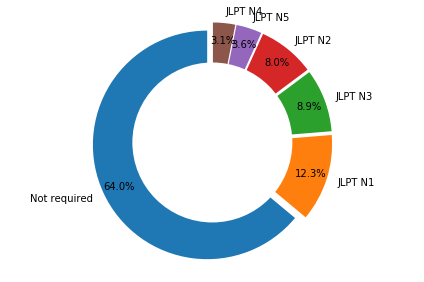

In [82]:
tester = df_merger['jlpt tag'].value_counts()
size = list(tester)
labels = ['Not required', 'JLPT N1', 'JLPT N3', 'JLPT N2', 'JLPT N5', 'JLPT N4']
explode = (0.05,0.05,0.05,0.05, 0.05, 0.05)
 
plt.pie(size, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.axis('equal')  
plt.tight_layout()
plt.show()

What this information tells us is that based on the data held by the Jisho.org website is that it only takes 6,329 words to become proficient in a language. But what seems to be off with these numbers are that if you were to do a general google search of the JLPT N-series tests:
<br><br>

<center>"The N1 is the most difficult level of the Japanese Language Proficiency Test (JLPT). To pass JLPT N1, you will need to know about 2,000 kanji and about 10,000 vocabulary words total."</center>

from [kawakawalearningstudio.com](https://kawakawalearningstudio.com/all/preparing-jlpt-n1-test/)

But if we were to look at the N2 test online it says that you need about 6,000 words total to be considered N2 proficient. So either the list we have from Jisho.org is not accurately listing words or there are many words that are not considered common words that are part of the JLPT that are not the most common words you would use in the language. 

Ultimately this information would need several sources to cross-validate with to see if the website is wrong or if it is correct but not showing them due to the words infrequency.

# 3.2
### Verb Tags
One thing that I wanted to emphasize within the dataframe is that verbs--while being the most difficult category to clean and properly create--actually make up a very small percentage of words in Japanese.

In [83]:
tester = df_merger['verb_tag'].value_counts()
print('Total size of dataframe: \t', tester.sum(), '\n\n Size of each category: \n', tester)

Total size of dataframe: 	 17558 

 Size of each category: 
 Not Verb    13372
suru         2754
ichidan       479
ru            329
su            215
mu            112
u             108
ku            106
gu             30
tsu            23
bu             16
ku_s            5
aru             4
kuru            4
nu              1
Name: verb_tag, dtype: int64


There are primarily three groups of verbs in Japanese, Ichidan, Godan, and Irregular verbs. We will also have the not verb category be included so we'll consolidate the labels so the pie chart doesn't become a glob of names over each other.

    1. Ichidan Verbs
        Already completed since they have the same conjugation so I kept them in one group. 479
    2. Godan Verbs
        Everything except kuru and suru are in this group. So the total for those are: 949
    3. Irregular Verbs
        Just kuru and suru are in this group. So the total is 2758
    4. Not Verbs
        Already a completed category as well of 13,372

All four of these groups add up to the sum of values within the dataframe so let's create the labels and sizes

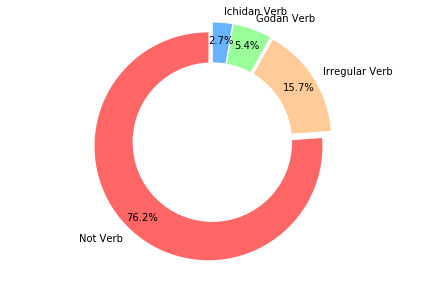

In [84]:
size = ['13372', '2758', '949', '479']
labels = ['Not Verb', 'Irregular Verb', 'Godan Verb', 'Ichidan Verb']
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
explode = (0.05,0.05,0.05,0.05)
 
plt.pie(size, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.axis('equal')  
plt.tight_layout()
plt.show()

Amongst the words in the dataframe, 4,186 of them are verbs. And within that only 949 of them constitute over 75% of the rare conjugations and exceptions that you have within Japansese verb conjugation. These verbs are what make this the hardest category to program for due to the size versus value being so completely imbalanced. The other remaining 3,000+ verbs make up only three of the fourteen conjugation groups and are by far the easier/more consistent conjugations. 

The reason that I emphasize this with a visualization is that while a language may be complex and have many underlying layers of grammar, one of the most difficult problems that this project has will be from less than 6% of the data.

# 4.0

## Final Thoughts
After everything that I have brought up within the the EDA and the visualizations I would like to consolidate that information into a small conclusion of what is accomplished and what is needind to be worked upon still.

### What this program completed
    - Created a web scraper with definitions, proper tags, and accompanying metadata
    - Cleaned up tags and refined educational meta data
    - Created new columns to assist with an easier stemming and lemmatization later on
    - Laid groundwork for pronunciation column
    
### What this program will continue
    - Inclusion of other parts of speech columns
    - A second dictionary to scrape for cross validation
    - Proper pronunciation column information (obtained from secondary dictionary)
    - Filling out more Parts of Speech columns
    - Recreation of definition column
    
While it may seem like there will always be more to work on with a project like this, what was completed already is a small undertaking in its own right but is far from becoming a full supplement just yet.

However, based on what is currently completed, please look into the Japanese NLTK Support program that is the sister program to this that goes into detail what we take from this dataframe. 